In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [10]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = True
overlap_thr= None

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print('making dirs')
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single


## Output dirs

In [11]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None \
    and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls
dff-ROC__stimulus__matchRF__C1.00


## Check input data

In [12]:
import _pickle as pkl
input_id = '__'.join(aggr_id.split('__')[0:-1])
input_files = glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s.pkl' % input_id))
#input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
print(len(input_files))
#input_fpath = input_files[0]
i_=[]
for ipath in input_files:
    with open(ipath, 'rb') as f:
        icells = pkl.load(f)
    i_.append(icells)
inputcells = pd.concat(i_, axis=0)

3


In [42]:
inputcells.columns

Index(['datakey', 'cell', 'x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset',
       'amplitude', 'r2', 'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area',
       'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg', 'major_axis',
       'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index', 'visual_area',
       'experiment', 'global_ix'],
      dtype='object')

<IPython.core.display.Javascript object>


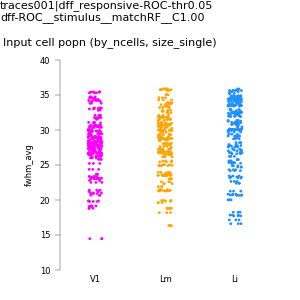

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls input_cell_distribution__dff-ROC__stimulus__matchRF__C1.00


In [159]:
fig, ax = pl.subplots(figsize=(3,3))

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
# sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
#              markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)
figname = 'input_cell_distribution__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [19]:
aggr_id

'dff-ROC__stimulus__matchRF__C1.00'

## Load

In [35]:
max_ncells = 96 # if match_rfs and (responsive_test=='ROC')

experiment = 'gratings' if class_name=='ori' else 'blobs'
m_=[]
for match_rf_flag in [True, False]:
    iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rf_flag, overlap_thr=overlap_thr)

    sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
                   and s!=169]
    iterdf = iterdf[iterdf['n_cells'].isin(sample_sizes)]
    # Group means
    grouper = ['visual_area', 'condition', 'iteration']
    mean_df0 = dec.average_within_iterations_by_ncells(iterdf, 
                                analysis_type=analysis_type, test_type=test_type,
                                grouper=grouper) 
    mean_df0['rfs'] = 'matched' if match_rf_flag else 'all'
    mean_df0['match_rfs'] = match_rf_flag
    m_.append(mean_df0)


(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
['visual_area', 'condition', 'iteration', 'n_cells', 'novel']
(Li) Found 10 paths
(Lm) Found 10 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
['visual_area', 'condition', 'iteration', 'n_cells', 'novel']


In [114]:
n_iters = iterdf['iteration'].max() +1
xlabels = [1, 32, 96, max_ncells]
mean_df = pd.concat(m_, axis=0).reset_index(drop=True)

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("rfs:", mean_df['rfs'].unique())


mean_df['novel_labels'] = None
mean_df.loc[mean_df['novel'], 'novel_labels'] = 'novel'
mean_df.loc[~mean_df['novel'], 'novel_labels'] = 'trained'

novel: [False  True]
conditions: ['data' 'shuffled']
rfs: ['matched' 'all']


In [115]:
mean_df.groupby(['visual_area', 'condition', 'train_transform', 'test_transform', 'novel', 'rfs', 'n_cells']).count()

iteration  \
visual_area condition train_transform test_transform novel rfs     n_cells              
Li          data      30.0            30.0           False all     1              500   
                                                                   2              500   
                                                                   4              500   
                                                                   8              500   
                                                                   16             500   
...                                                                               ...   
V1          shuffled  30.0            30.0           False matched 8              500   
                                                                   16             500   
                                                                   32             500   
                                                                   64             500   
                                                                   96             500   

                                                                            fit_time  \
visual_area condition train_transform test_transform novel rfs     n_cells             
Li          data      30.0            30.0           False all     1             500   
                                                                   2             500   
                                                                   4             500   
                                                                   8             500   
                                                                   16            500   
...                                                                              ...   
V1          shuffled  30.0            30.0           False matched 8             500   
                                                                   16            500   
                                                                   32            500   
                                                                   64            500   
                                                                   96            500   

                                                                            score_time  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                                   16              500   
...                                                                                ...   
V1          shuffled  30.0            30.0           False matched 8               500   
                                                                   16              500   
                                                                   32              500   
                                                                   64              500   
                                                                   96              500   

                                                                            test_score  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                              

In [116]:
print_index = ['visual_area','rfs', 'novel']

if test_type is not None:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=print_index, columns='n_cells')
else:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area'], columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__matchRF__C1.00


heldout_test_score                                \
n_cells                                   1         2         4         8    
visual_area rfs     novel                                                    
Li          all     False           0.514566  0.521792  0.541963  0.555068   
                    True            0.512347  0.520390  0.528657  0.539456   
            matched False           0.535555  0.555703  0.585391  0.607603   
                    True            0.536457  0.547944  0.571630  0.593906   
Lm          all     False           0.518542  0.535697  0.553942  0.574979   
                    True            0.513441  0.522489  0.531605  0.537958   
            matched False           0.529367  0.538167  0.555733  0.578900   
                    True            0.520351  0.527039  0.538333  0.554007   
V1          all     False           0.535391  0.559851  0.581700  0.615600   
                    True            0.520353  0.526662  0.543042  0.562101   
            matched False           0.549390  0.573081  0.612667  0.650567   
                    True            0.528450  0.538147  0.560299  0.580308   

                                                                   
n_cells                          16        32        64        96  
visual_area rfs     novel                                          
Li          all     False  0.568285  0.587394  0.638783  0.670803  
                    True   0.548230  0.565075  0.594145  0.618094  
            matched False  0.643817  0.682259  0.765552  0.812609  
                    True   0.626433  0.654182  0.713580  0.747681  
Lm          all     False  0.589030  0.600667  0.666364  0.705648  
                    True   0.548986  0.560324  0.588188  0.607315  
            matched False  0.594600  0.624233  0.676500  0.705933  
                    True   0.565181  0.579734  0.612484  0.640829  
V1          all     False  0.648600  0.679600  0.751233  0.801900  
                    True   0.577155  0.595760  0.637393  0.668683  
            matched False  0.690100  0.728733  0.815833  0.853033  
                    True   0.607134  0.634751  0.681319  0.712993

<IPython.core.display.Javascript object>


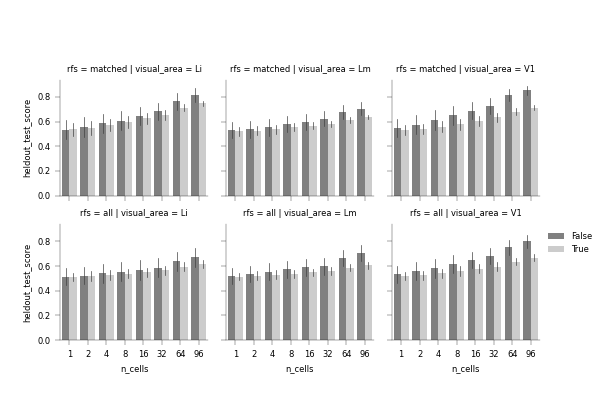

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [168]:
novel_colors={True: [0.8]*3, False: [0.5]*3}
plotd = mean_df[mean_df.condition=='data']
g = sns.FacetGrid(col='visual_area', row='rfs', data=plotd, height=2)
g.map(sns.barplot, 'n_cells', 'heldout_test_score', 'novel', ci='sd',
     palette=novel_colors, errwidth=0.5)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.8)

In [118]:
area_colors2 = {'V1': 'darkmagenta', 'Lm': 'saddlebrown', 'Li': 'darkblue'}

In [119]:
pl.rcParams['legend.title_fontsize'] = 8


<IPython.core.display.Javascript object>


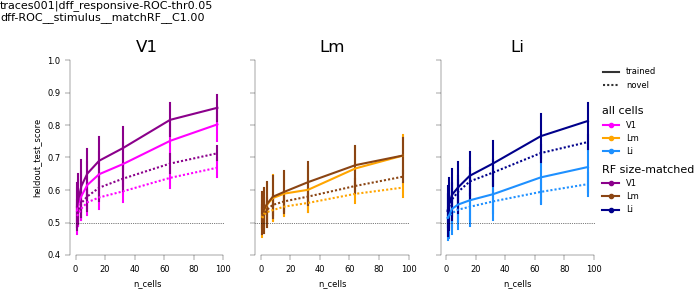

2 [<matplotlib.lines.Line2D object at 0x2b34a26a1350>, <matplotlib.lines.Line2D object at 0x2b34a3954310>, <matplotlib.lines.Line2D object at 0x2b34a3954f10>, <matplotlib.lines.Line2D object at 0x2b34a38df050>]
1 [<matplotlib.lines.Line2D object at 0x2b34a329c550>, <matplotlib.lines.Line2D object at 0x2b34a329c210>, <matplotlib.lines.Line2D object at 0x2b34a22d0b10>, <matplotlib.lines.Line2D object at 0x2b34a22d0150>]
2
0 [<matplotlib.lines.Line2D object at 0x2b34a39da750>, <matplotlib.lines.Line2D object at 0x2b34a2b50f50>, <matplotlib.lines.Line2D object at 0x2b34a236d190>, <matplotlib.lines.Line2D object at 0x2b34a236d810>]


In [161]:
metric='heldout_test_score'

plotd = mean_df[mean_df.condition=='data']

#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)

for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]; ax.set_title(va);
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='all'], ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors[va])
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='matched'],ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors2[va])
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.set_ylim([0.4, 1])
    print(ai, ax.legend_.legendHandles)
    if ai==1:
        leg_h = ax.legend_.legendHandles[0:2]
        print(len(leg_h))
        leg = ax.legend(handles=leg_h, bbox_to_anchor=(2.2,1.), loc='upper left', 
                  frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.legend_.remove()

sns.despine(trim=True)

leg_h2 = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas], 
                                     labels=visual_areas, marker='.')
leg = axn[-1].legend(handles=leg_h2, bbox_to_anchor=(1,0.8), loc='upper left', 
               frameon=False, title='all cells')
leg._legend_box.align = "left"

leg_h3 = pplot.custom_legend_markers(colors=[area_colors2[v] for v in visual_areas], 
                                     labels=visual_areas, marker='.')
leg = axn[0].legend(handles=leg_h3, bbox_to_anchor=(3.4,0.5), loc='upper left', 
               frameon=False, title='RF size-matched', fontsize=6)
leg._legend_box.align = "left"

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, wspace=0.2, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'accuracy_byncell_curves_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [165]:
import itertools
max_ncells

96

In [169]:
plotd = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]
plotd.head()


,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,train_transform,test_transform,n_trials,randi_cells,intact,rfs,match_rfs,novel_labels
14,Li,data,0,96,False,0.001201,0.000293,0.740000,1.0,0.825000,1.0,3726.2,30.0,30.0,38.0,2538.0,True,matched,True,trained
15,Li,data,0,96,True,0.001201,0.000293,0.740000,1.0,0.706579,1.0,3726.2,30.0,30.0,38.0,2538.0,True,matched,True,novel
30,Li,data,1,96,False,0.000758,0.000310,0.853333,1.0,0.825000,1.0,4638.4,30.0,30.0,38.0,7280.0,True,matched,True,trained
31,Li,data,1,96,True,0.000758,0.000310,0.853333,1.0,0.751316,1.0,4638.4,30.0,30.0,38.0,7280.0,True,matched,True,novel
46,Li,data,2,96,False,0.000740,0.000296,0.793333,1.0,0.850000,1.0,4090.0,30.0,30.0,38.0,8617.0,True,matched,True,trained


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


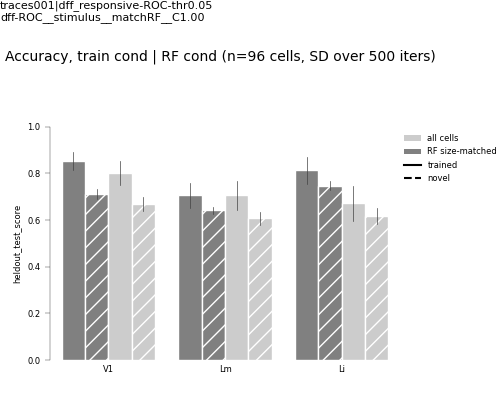

In [170]:
%matplotlib notebook
plotd['plotcond'] = ['%s_%s' %  (r, n) for r, n in plotd[['rfs', 'novel_labels']].values]

matchrf_color = [0.5]*3
all_color = [0.8]*3
plot_palette = {'all_trained': all_color, 'all_novel': all_color,
                'matched_trained': matchrf_color, 'matched_novel': matchrf_color}
keys = ['matched_trained', 'matched_novel', 'all_trained', 'all_novel']
fig, ax = pl.subplots(figsize=(5,4))
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
           hue='plotcond', hue_order=keys,
           palette=plot_palette, 
           edgecolor='w', order=visual_areas, ci='sd', errwidth=0.5)
# legends
leg_h = pplot.custom_legend_markers(colors=[all_color, matchrf_color],
                                    labels=['all cells', 'RF size-matched'],
                                    use_patch=True)
leg_h2 = pplot.custom_legend_markers(colors=['k', 'k'],
                                    labels=['trained', 'novel'],marker=None,
                                    linestyles=['-', '--'], use_patch=False)
ax.legend(handles=leg_h+leg_h2, bbox_to_anchor=(0.99,1), 
          loc='upper left', frameon=False)

bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(2, anchor='SW')
ax.set_ylim([0, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.85,\
         'Accuracy, train cond | RF cond (n=%i cells, SD over %i iters)' \
         % (max_ncells, n_iters))

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'compare_performance_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [180]:
d_list=[]
for (va, data_cond, rf_cond), cg in plotd.sort_values(by='iteration')\
                .groupby(['visual_area', 'condition', 'rfs']):

    novel_scores = cg[cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    trained_scores = cg[~cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    diffs = trained_scores - novel_scores
    df_ = pd.DataFrame({'trained_minus_novel': diffs})
    df_['visual_area'] = va
    df_['condition'] = data_cond
    df_['rfs'] = rf_cond
    df_['iteration'] = cg[cg.novel].sort_values(by='iteration')['iteration'].values
    d_list.append(df_)
diffdf = pd.concat(d_list, axis=0)


<IPython.core.display.Javascript object>


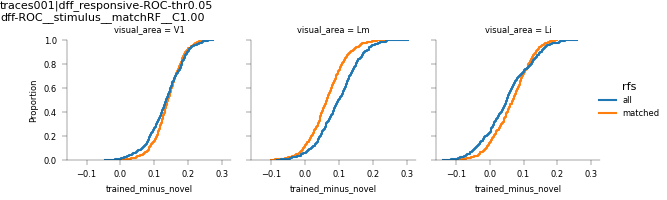

In [192]:
# fig, ax = pl.subplots()
g = sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='ecdf', 
           )
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'diff_trained-minus-novel_matchrf-v-all'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


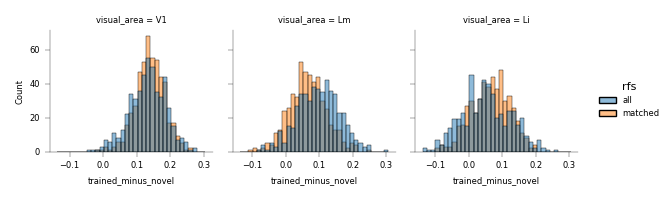

In [189]:
sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='hist'
           )